In [119]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

In [120]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [132]:
df_a = pd.read_csv("names_2000_2019.csv")
df = df_a[df_a["Płeć"]=="M"]
df["Płeć"] = "MĘŻCZYZNA"
df = df.rename(columns={"Imię":"IMIĘ_PIERWSZE", "Płeć":"PŁEĆ", "Liczba":"LICZBA_WYSTĄPIEŃ"})


C:\Users\MSI\AppData\Local\Temp\ipykernel_21892\2670712180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Płeć"] = "MĘŻCZYZNA"


In [133]:
for i in range(2020,2024):
    df_temp = pd.read_csv(f"male_names_{i}.csv")
    df_temp["Rok"] = i
    print(df_temp)
    df = pd.concat([df,df_temp], ignore_index=True)

df


    IMIĘ_PIERWSZE       PŁEĆ  LICZBA_WYSTĄPIEŃ   Rok
0          ANTONI  MĘŻCZYZNA              8368  2020
1             JAN  MĘŻCZYZNA              7658  2020
2      ALEKSANDER  MĘŻCZYZNA              7165  2020
3           JAKUB  MĘŻCZYZNA              7162  2020
4      FRANCISZEK  MĘŻCZYZNA              7124  2020
..            ...        ...               ...   ...
794          EZRA  MĘŻCZYZNA                 2  2020
795     MINH QUAN  MĘŻCZYZNA                 2  2020
796        MARTÍN  MĘŻCZYZNA                 2  2020
797       EDUARDO  MĘŻCZYZNA                 2  2020
798         NAMIR  MĘŻCZYZNA                 2  2020

[799 rows x 4 columns]
    IMIĘ_PIERWSZE       PŁEĆ  LICZBA_WYSTĄPIEŃ   Rok
0          ANTONI  MĘŻCZYZNA              7821  2021
1             JAN  MĘŻCZYZNA              6975  2021
2      ALEKSANDER  MĘŻCZYZNA              6919  2021
3      FRANCISZEK  MĘŻCZYZNA              6629  2021
4           JAKUB  MĘŻCZYZNA              6427  2021
..            ...     

,Rok,IMIĘ_PIERWSZE,LICZBA_WYSTĄPIEŃ,PŁEĆ
0,2000,JAKUB,14497,MĘŻCZYZNA
1,2000,MATEUSZ,11454,MĘŻCZYZNA
2,2000,KACPER,8898,MĘŻCZYZNA
3,2000,MICHAŁ,8498,MĘŻCZYZNA
4,2000,PATRYK,7743,MĘŻCZYZNA
...,...,...,...,...
15780,2023,ELISEI,2,MĘŻCZYZNA
15781,2023,JON,2,MĘŻCZYZNA
15782,2023,FLAVIO,2,MĘŻCZYZNA
15783,2023,DEYAN,2,MĘŻCZYZNA


In [134]:
yearly_counts = df.groupby(by="Rok").agg({"LICZBA_WYSTĄPIEŃ":"sum"})
yearly_counts = yearly_counts.rename(columns={"LICZBA_WYSTĄPIEŃ":"LW_ROCZNA"})

In [135]:
df = pd.merge(df,yearly_counts, on="Rok")
df

,Rok,IMIĘ_PIERWSZE,LICZBA_WYSTĄPIEŃ,PŁEĆ,LW_ROCZNA
0,2000,JAKUB,14497,MĘŻCZYZNA,197263
1,2000,MATEUSZ,11454,MĘŻCZYZNA,197263
2,2000,KACPER,8898,MĘŻCZYZNA,197263
3,2000,MICHAŁ,8498,MĘŻCZYZNA,197263
4,2000,PATRYK,7743,MĘŻCZYZNA,197263
...,...,...,...,...,...
15780,2023,ELISEI,2,MĘŻCZYZNA,145349
15781,2023,JON,2,MĘŻCZYZNA,145349
15782,2023,FLAVIO,2,MĘŻCZYZNA,145349
15783,2023,DEYAN,2,MĘŻCZYZNA,145349


In [136]:
df["PROCENT_WYSTĄPIEŃ"] = df.LICZBA_WYSTĄPIEŃ/df.LW_ROCZNA*100
df.Rok = pd.to_datetime(df['Rok'].astype(str) + '-12-31')
df = df.rename(columns={"Rok":"ds","PROCENT_WYSTĄPIEŃ":"y"})

In [137]:
top_names = df[df.y > 0.1].IMIĘ_PIERWSZE.unique()
df = df[df.IMIĘ_PIERWSZE.isin(top_names)]


In [154]:
train = df.loc[df.ds <= "2021-12-31"]
valid = df.loc[df.ds > "2021-12-31"]

In [155]:
p = []

for name in train["IMIĘ_PIERWSZE"].unique():
    print("name: ", name)
    train_ = train.loc[train.IMIĘ_PIERWSZE == name]
    valid_ = valid.loc[valid.IMIĘ_PIERWSZE == name]

    m = Prophet(seasonality_mode="additive")
    m.fit(train_)

    future = m.make_future_dataframe(periods = 3, freq="Y", include_history=True)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['IMIĘ_PIERWSZE'] = name
    p.append(forecast[['ds', 'yhat', 'IMIĘ_PIERWSZE']])

p = pd.concat(p, ignore_index=True)
p['yhat'] = p['yhat'].clip(lower=0)





22:38:55 - cmdstanpy - INFO - Chain [1] start processing


name:  JAKUB


22:38:55 - cmdstanpy - INFO - Chain [1] done processing
22:38:55 - cmdstanpy - INFO - Chain [1] start processing
22:38:55 - cmdstanpy - INFO - Chain [1] done processing


name:  MATEUSZ


22:38:55 - cmdstanpy - INFO - Chain [1] start processing
22:38:55 - cmdstanpy - INFO - Chain [1] done processing


name:  KACPER


22:38:55 - cmdstanpy - INFO - Chain [1] start processing


name:  MICHAŁ


22:38:55 - cmdstanpy - INFO - Chain [1] done processing
22:38:56 - cmdstanpy - INFO - Chain [1] start processing


name:  PATRYK


22:38:56 - cmdstanpy - INFO - Chain [1] done processing
22:38:56 - cmdstanpy - INFO - Chain [1] start processing
22:38:56 - cmdstanpy - INFO - Chain [1] done processing


name:  DAWID


22:38:56 - cmdstanpy - INFO - Chain [1] start processing


name:  KAMIL


22:38:56 - cmdstanpy - INFO - Chain [1] done processing
22:38:56 - cmdstanpy - INFO - Chain [1] start processing


name:  PIOTR


22:38:57 - cmdstanpy - INFO - Chain [1] done processing
22:38:57 - cmdstanpy - INFO - Chain [1] start processing


name:  SZYMON


22:38:57 - cmdstanpy - INFO - Chain [1] done processing
22:38:57 - cmdstanpy - INFO - Chain [1] start processing


name:  PAWEŁ


22:38:57 - cmdstanpy - INFO - Chain [1] done processing
22:38:57 - cmdstanpy - INFO - Chain [1] start processing
22:38:57 - cmdstanpy - INFO - Chain [1] done processing


name:  MACIEJ
name:  BARTOSZ


22:38:57 - cmdstanpy - INFO - Chain [1] start processing
22:38:57 - cmdstanpy - INFO - Chain [1] done processing
22:38:58 - cmdstanpy - INFO - Chain [1] start processing


name:  DAMIAN


22:38:58 - cmdstanpy - INFO - Chain [1] done processing
22:38:58 - cmdstanpy - INFO - Chain [1] start processing


name:  DOMINIK


22:38:58 - cmdstanpy - INFO - Chain [1] done processing
22:38:58 - cmdstanpy - INFO - Chain [1] start processing


name:  ADRIAN


22:38:58 - cmdstanpy - INFO - Chain [1] done processing
22:38:58 - cmdstanpy - INFO - Chain [1] start processing


name:  MARCIN


22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing


name:  ŁUKASZ


22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing


name:  KRZYSZTOF
name:  DANIEL


22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing


name:  SEBASTIAN


22:39:00 - cmdstanpy - INFO - Chain [1] start processing


name:  TOMASZ


22:39:00 - cmdstanpy - INFO - Chain [1] done processing
22:39:00 - cmdstanpy - INFO - Chain [1] start processing


name:  FILIP


22:39:00 - cmdstanpy - INFO - Chain [1] done processing
22:39:00 - cmdstanpy - INFO - Chain [1] start processing


name:  ADAM


22:39:00 - cmdstanpy - INFO - Chain [1] done processing
22:39:00 - cmdstanpy - INFO - Chain [1] start processing


name:  BARTŁOMIEJ


22:39:00 - cmdstanpy - INFO - Chain [1] done processing
22:39:01 - cmdstanpy - INFO - Chain [1] start processing
22:39:01 - cmdstanpy - INFO - Chain [1] done processing


name:  KAROL


22:39:01 - cmdstanpy - INFO - Chain [1] start processing


name:  MIKOŁAJ


22:39:01 - cmdstanpy - INFO - Chain [1] done processing
22:39:01 - cmdstanpy - INFO - Chain [1] start processing


name:  KRYSTIAN


22:39:01 - cmdstanpy - INFO - Chain [1] done processing
22:39:01 - cmdstanpy - INFO - Chain [1] start processing
22:39:01 - cmdstanpy - INFO - Chain [1] done processing


name:  HUBERT


22:39:02 - cmdstanpy - INFO - Chain [1] start processing


name:  KONRAD


22:39:02 - cmdstanpy - INFO - Chain [1] done processing
22:39:02 - cmdstanpy - INFO - Chain [1] start processing


name:  WOJCIECH


22:39:02 - cmdstanpy - INFO - Chain [1] done processing
22:39:02 - cmdstanpy - INFO - Chain [1] start processing


name:  RAFAŁ


22:39:02 - cmdstanpy - INFO - Chain [1] done processing
22:39:02 - cmdstanpy - INFO - Chain [1] start processing
22:39:03 - cmdstanpy - INFO - Chain [1] done processing


name:  JAN


22:39:03 - cmdstanpy - INFO - Chain [1] start processing


name:  PRZEMYSŁAW


22:39:03 - cmdstanpy - INFO - Chain [1] done processing
22:39:03 - cmdstanpy - INFO - Chain [1] start processing


name:  OSKAR


22:39:03 - cmdstanpy - INFO - Chain [1] done processing
22:39:03 - cmdstanpy - INFO - Chain [1] start processing


name:  GRZEGORZ


22:39:03 - cmdstanpy - INFO - Chain [1] done processing
22:39:03 - cmdstanpy - INFO - Chain [1] start processing


name:  WIKTOR


22:39:04 - cmdstanpy - INFO - Chain [1] done processing
22:39:04 - cmdstanpy - INFO - Chain [1] start processing


name:  ARKADIUSZ


22:39:04 - cmdstanpy - INFO - Chain [1] done processing
22:39:04 - cmdstanpy - INFO - Chain [1] start processing


name:  ALEKSANDER


22:39:04 - cmdstanpy - INFO - Chain [1] done processing
22:39:04 - cmdstanpy - INFO - Chain [1] start processing


name:  ARTUR


22:39:04 - cmdstanpy - INFO - Chain [1] done processing
22:39:04 - cmdstanpy - INFO - Chain [1] start processing


name:  RADOSŁAW


22:39:05 - cmdstanpy - INFO - Chain [1] done processing
22:39:05 - cmdstanpy - INFO - Chain [1] start processing
22:39:05 - cmdstanpy - INFO - Chain [1] done processing


name:  ROBERT


22:39:05 - cmdstanpy - INFO - Chain [1] start processing


name:  MAREK


22:39:05 - cmdstanpy - INFO - Chain [1] done processing
22:39:05 - cmdstanpy - INFO - Chain [1] start processing
22:39:05 - cmdstanpy - INFO - Chain [1] done processing


name:  ERYK


22:39:05 - cmdstanpy - INFO - Chain [1] start processing
22:39:06 - cmdstanpy - INFO - Chain [1] done processing


name:  MARCEL
name:  NORBERT


22:39:06 - cmdstanpy - INFO - Chain [1] start processing
22:39:06 - cmdstanpy - INFO - Chain [1] done processing
22:39:06 - cmdstanpy - INFO - Chain [1] start processing


name:  MARIUSZ


22:39:06 - cmdstanpy - INFO - Chain [1] done processing
22:39:06 - cmdstanpy - INFO - Chain [1] start processing


name:  ANDRZEJ


22:39:06 - cmdstanpy - INFO - Chain [1] done processing
22:39:06 - cmdstanpy - INFO - Chain [1] start processing


name:  MAKSYMILIAN


22:39:07 - cmdstanpy - INFO - Chain [1] done processing
22:39:07 - cmdstanpy - INFO - Chain [1] start processing
22:39:07 - cmdstanpy - INFO - Chain [1] done processing


name:  JACEK


22:39:07 - cmdstanpy - INFO - Chain [1] start processing
22:39:07 - cmdstanpy - INFO - Chain [1] done processing


name:  MIŁOSZ
name:  DARIUSZ


22:39:07 - cmdstanpy - INFO - Chain [1] start processing
22:39:07 - cmdstanpy - INFO - Chain [1] done processing
22:39:07 - cmdstanpy - INFO - Chain [1] start processing


name:  CEZARY


22:39:07 - cmdstanpy - INFO - Chain [1] done processing
22:39:08 - cmdstanpy - INFO - Chain [1] start processing


name:  IGOR


22:39:08 - cmdstanpy - INFO - Chain [1] done processing
22:39:08 - cmdstanpy - INFO - Chain [1] start processing


name:  BŁAŻEJ


22:39:08 - cmdstanpy - INFO - Chain [1] done processing
22:39:08 - cmdstanpy - INFO - Chain [1] start processing
22:39:08 - cmdstanpy - INFO - Chain [1] done processing


name:  GABRIEL
name:  JAROSŁAW


22:39:08 - cmdstanpy - INFO - Chain [1] start processing
22:39:08 - cmdstanpy - INFO - Chain [1] done processing
22:39:09 - cmdstanpy - INFO - Chain [1] start processing
22:39:09 - cmdstanpy - INFO - Chain [1] done processing


name:  ALAN
name:  STANISŁAW


22:39:09 - cmdstanpy - INFO - Chain [1] start processing
22:39:09 - cmdstanpy - INFO - Chain [1] done processing
22:39:09 - cmdstanpy - INFO - Chain [1] start processing
22:39:09 - cmdstanpy - INFO - Chain [1] done processing


name:  GRACJAN
name:  NIKODEM


22:39:09 - cmdstanpy - INFO - Chain [1] start processing
22:39:09 - cmdstanpy - INFO - Chain [1] done processing
22:39:09 - cmdstanpy - INFO - Chain [1] start processing
22:39:09 - cmdstanpy - INFO - Chain [1] done processing


name:  EMIL


22:39:10 - cmdstanpy - INFO - Chain [1] start processing


name:  ALBERT


22:39:10 - cmdstanpy - INFO - Chain [1] done processing
22:39:10 - cmdstanpy - INFO - Chain [1] start processing
22:39:10 - cmdstanpy - INFO - Chain [1] done processing


name:  ANTONI


22:39:10 - cmdstanpy - INFO - Chain [1] start processing


name:  DENIS


22:39:10 - cmdstanpy - INFO - Chain [1] done processing
22:39:10 - cmdstanpy - INFO - Chain [1] start processing


name:  ERNEST


22:39:10 - cmdstanpy - INFO - Chain [1] done processing
22:39:11 - cmdstanpy - INFO - Chain [1] start processing
22:39:11 - cmdstanpy - INFO - Chain [1] done processing


name:  FABIAN


22:39:11 - cmdstanpy - INFO - Chain [1] start processing


name:  SŁAWOMIR


22:39:11 - cmdstanpy - INFO - Chain [1] done processing
22:39:11 - cmdstanpy - INFO - Chain [1] start processing


name:  TOBIASZ


22:39:11 - cmdstanpy - INFO - Chain [1] done processing
22:39:11 - cmdstanpy - INFO - Chain [1] start processing


name:  TYMOTEUSZ


22:39:11 - cmdstanpy - INFO - Chain [1] done processing
22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1] done processing


name:  OLAF


22:39:12 - cmdstanpy - INFO - Chain [1] start processing


name:  JĘDRZEJ


22:39:12 - cmdstanpy - INFO - Chain [1] done processing
22:39:12 - cmdstanpy - INFO - Chain [1] start processing


name:  SYLWESTER


22:39:12 - cmdstanpy - INFO - Chain [1] done processing
22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1] done processing


name:  FRANCISZEK


22:39:13 - cmdstanpy - INFO - Chain [1] start processing


name:  SEWERYN


22:39:13 - cmdstanpy - INFO - Chain [1] done processing
22:39:13 - cmdstanpy - INFO - Chain [1] start processing


name:  REMIGIUSZ


22:39:13 - cmdstanpy - INFO - Chain [1] done processing
22:39:13 - cmdstanpy - INFO - Chain [1] start processing


name:  KAJETAN


22:39:13 - cmdstanpy - INFO - Chain [1] done processing
22:39:13 - cmdstanpy - INFO - Chain [1] start processing
22:39:13 - cmdstanpy - INFO - Chain [1] done processing


name:  KUBA


22:39:13 - cmdstanpy - INFO - Chain [1] start processing


name:  KORNEL


22:39:14 - cmdstanpy - INFO - Chain [1] done processing
22:39:14 - cmdstanpy - INFO - Chain [1] start processing
22:39:14 - cmdstanpy - INFO - Chain [1] done processing


name:  KEWIN


22:39:14 - cmdstanpy - INFO - Chain [1] start processing
22:39:14 - cmdstanpy - INFO - Chain [1] done processing


name:  BRAJAN


22:39:14 - cmdstanpy - INFO - Chain [1] start processing


name:  JULIAN


22:39:14 - cmdstanpy - INFO - Chain [1] done processing
22:39:14 - cmdstanpy - INFO - Chain [1] start processing


name:  KEVIN


22:39:14 - cmdstanpy - INFO - Chain [1] done processing
22:39:15 - cmdstanpy - INFO - Chain [1] start processing


name:  DORIAN


22:39:15 - cmdstanpy - INFO - Chain [1] done processing
22:39:15 - cmdstanpy - INFO - Chain [1] start processing
22:39:15 - cmdstanpy - INFO - Chain [1] done processing


name:  CYPRIAN


22:39:15 - cmdstanpy - INFO - Chain [1] start processing


name:  WITOLD


22:39:15 - cmdstanpy - INFO - Chain [1] done processing
22:39:15 - cmdstanpy - INFO - Chain [1] start processing
22:39:15 - cmdstanpy - INFO - Chain [1] done processing


name:  NATAN
name:  OLIWIER


22:39:15 - cmdstanpy - INFO - Chain [1] start processing
22:39:16 - cmdstanpy - INFO - Chain [1] done processing
22:39:16 - cmdstanpy - INFO - Chain [1] start processing
22:39:16 - cmdstanpy - INFO - Chain [1] done processing


name:  DAVID
name:  JERZY


22:39:16 - cmdstanpy - INFO - Chain [1] start processing
22:39:16 - cmdstanpy - INFO - Chain [1] done processing
22:39:16 - cmdstanpy - INFO - Chain [1] start processing
22:39:16 - cmdstanpy - INFO - Chain [1] done processing


name:  BENIAMIN


22:39:16 - cmdstanpy - INFO - Chain [1] start processing
22:39:16 - cmdstanpy - INFO - Chain [1] done processing


name:  ROMAN


22:39:17 - cmdstanpy - INFO - Chain [1] start processing


name:  SAMUEL


22:39:17 - cmdstanpy - INFO - Chain [1] done processing
22:39:17 - cmdstanpy - INFO - Chain [1] start processing
22:39:17 - cmdstanpy - INFO - Chain [1] done processing


name:  BORYS


22:39:17 - cmdstanpy - INFO - Chain [1] start processing
22:39:17 - cmdstanpy - INFO - Chain [1] done processing


name:  KORDIAN


22:39:17 - cmdstanpy - INFO - Chain [1] start processing


name:  JÓZEF


22:39:17 - cmdstanpy - INFO - Chain [1] done processing
22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:18 - cmdstanpy - INFO - Chain [1] done processing


name:  JULIUSZ


22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:18 - cmdstanpy - INFO - Chain [1] done processing


name:  ALEKS


22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:18 - cmdstanpy - INFO - Chain [1] done processing


name:  OLIWER
name:  TADEUSZ


22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:18 - cmdstanpy - INFO - Chain [1] done processing
22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:19 - cmdstanpy - INFO - Chain [1] done processing


name:  IGNACY


22:39:19 - cmdstanpy - INFO - Chain [1] start processing
22:39:19 - cmdstanpy - INFO - Chain [1] done processing


name:  KLAUDIUSZ


22:39:19 - cmdstanpy - INFO - Chain [1] start processing


name:  MAKSYM


22:39:19 - cmdstanpy - INFO - Chain [1] done processing
22:39:19 - cmdstanpy - INFO - Chain [1] start processing


name:  RYSZARD


22:39:19 - cmdstanpy - INFO - Chain [1] done processing
22:39:19 - cmdstanpy - INFO - Chain [1] start processing
22:39:19 - cmdstanpy - INFO - Chain [1] done processing


name:  ALEXANDER
name:  BRUNO


22:39:20 - cmdstanpy - INFO - Chain [1] start processing
22:39:20 - cmdstanpy - INFO - Chain [1] done processing
22:39:20 - cmdstanpy - INFO - Chain [1] start processing
22:39:20 - cmdstanpy - INFO - Chain [1] done processing


name:  ALEX


22:39:20 - cmdstanpy - INFO - Chain [1] start processing
22:39:20 - cmdstanpy - INFO - Chain [1] done processing


name:  OLIVER
name:  JEREMI


22:39:20 - cmdstanpy - INFO - Chain [1] start processing
22:39:20 - cmdstanpy - INFO - Chain [1] done processing
22:39:21 - cmdstanpy - INFO - Chain [1] start processing


name:  STEFAN


22:39:21 - cmdstanpy - INFO - Chain [1] done processing
22:39:21 - cmdstanpy - INFO - Chain [1] start processing
22:39:21 - cmdstanpy - INFO - Chain [1] done processing


name:  MIESZKO


22:39:21 - cmdstanpy - INFO - Chain [1] start processing
22:39:21 - cmdstanpy - INFO - Chain [1] done processing


name:  IWO
name:  MAXIMILIAN


22:39:21 - cmdstanpy - INFO - Chain [1] start processing
22:39:21 - cmdstanpy - INFO - Chain [1] done processing
22:39:22 - cmdstanpy - INFO - Chain [1] start processing


name:  MAURYCY


22:39:22 - cmdstanpy - INFO - Chain [1] done processing
22:39:22 - cmdstanpy - INFO - Chain [1] start processing
22:39:22 - cmdstanpy - INFO - Chain [1] done processing


name:  NATANIEL
name:  TYMON


22:39:22 - cmdstanpy - INFO - Chain [1] start processing
22:39:22 - cmdstanpy - INFO - Chain [1] done processing
22:39:22 - cmdstanpy - INFO - Chain [1] start processing


name:  LEON


22:39:22 - cmdstanpy - INFO - Chain [1] done processing
22:39:22 - cmdstanpy - INFO - Chain [1] start processing
22:39:23 - cmdstanpy - INFO - Chain [1] done processing


name:  HENRYK


22:39:23 - cmdstanpy - INFO - Chain [1] start processing


name:  KSAWERY


22:39:23 - cmdstanpy - INFO - Chain [1] done processing
22:39:23 - cmdstanpy - INFO - Chain [1] start processing


name:  KONSTANTY


22:39:23 - cmdstanpy - INFO - Chain [1] done processing
22:39:23 - cmdstanpy - INFO - Chain [1] start processing
22:39:23 - cmdstanpy - INFO - Chain [1] done processing


name:  OSCAR


22:39:23 - cmdstanpy - INFO - Chain [1] start processing


name:  FLORIAN


22:39:24 - cmdstanpy - INFO - Chain [1] done processing
22:39:24 - cmdstanpy - INFO - Chain [1] start processing
22:39:24 - cmdstanpy - INFO - Chain [1] done processing


name:  GUSTAW


22:39:24 - cmdstanpy - INFO - Chain [1] start processing
22:39:24 - cmdstanpy - INFO - Chain [1] done processing


name:  KAZIMIERZ


22:39:24 - cmdstanpy - INFO - Chain [1] start processing


name:  MILAN


22:39:24 - cmdstanpy - INFO - Chain [1] done processing
22:39:24 - cmdstanpy - INFO - Chain [1] start processing
22:39:24 - cmdstanpy - INFO - Chain [1] done processing


name:  LEONARD


22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing


name:  OLIVIER
name:  LUCJAN


22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing
22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing


name:  MARK


22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing


name:  OLEKSANDR


22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:26 - cmdstanpy - INFO - Chain [1] done processing


name:  LUDWIK


22:39:26 - cmdstanpy - INFO - Chain [1] start processing
22:39:26 - cmdstanpy - INFO - Chain [1] done processing


name:  NATHAN
name:  FELIKS


22:39:26 - cmdstanpy - INFO - Chain [1] start processing
22:39:26 - cmdstanpy - INFO - Chain [1] done processing
22:39:26 - cmdstanpy - INFO - Chain [1] start processing
22:39:26 - cmdstanpy - INFO - Chain [1] done processing


name:  LEO


22:39:26 - cmdstanpy - INFO - Chain [1] start processing
22:39:26 - cmdstanpy - INFO - Chain [1] done processing


name:  HUGO
name:  ARTEM


22:39:27 - cmdstanpy - INFO - Chain [1] start processing
22:39:27 - cmdstanpy - INFO - Chain [1] done processing
22:39:27 - cmdstanpy - INFO - Chain [1] start processing
22:39:27 - cmdstanpy - INFO - Chain [1] done processing


name:  TEODOR
name:  LIAM


22:39:27 - cmdstanpy - INFO - Chain [1] start processing
22:39:27 - cmdstanpy - INFO - Chain [1] done processing
22:39:27 - cmdstanpy - INFO - Chain [1] start processing
22:39:27 - cmdstanpy - INFO - Chain [1] done processing


name:  TYMOFII
name:  MATVII


22:39:27 - cmdstanpy - INFO - Chain [1] start processing
22:39:27 - cmdstanpy - INFO - Chain [1] done processing


In [156]:
p = p.merge(pd.concat([train,valid], ignore_index=True), on=['ds', 'IMIĘ_PIERWSZE'], how='left')

In [157]:
wmape(p['y'], p['yhat'])

0.13263880369037273

In [158]:
p[p.IMIĘ_PIERWSZE=="JAKUB"]

,ds,yhat,IMIĘ_PIERWSZE,LICZBA_WYSTĄPIEŃ,PŁEĆ,LW_ROCZNA,y
0,2000-12-31,9.162166,JAKUB,14497.0,MĘŻCZYZNA,197263.0,7.349072
1,2001-12-31,9.060911,JAKUB,18612.0,MĘŻCZYZNA,191947.0,9.696427
2,2002-12-31,8.865634,JAKUB,18018.0,MĘŻCZYZNA,185415.0,9.717660
3,2003-12-31,8.576220,JAKUB,16429.0,MĘŻCZYZNA,183215.0,8.967061
4,2004-12-31,7.986235,JAKUB,16431.0,MĘŻCZYZNA,186903.0,8.791191
5,2005-12-31,7.884980,JAKUB,15802.0,MĘŻCZYZNA,192820.0,8.195208
6,2006-12-31,7.689703,JAKUB,15756.0,MĘŻCZYZNA,200796.0,7.846770
7,2007-12-31,7.400289,JAKUB,16118.0,MĘŻCZYZNA,211946.0,7.604767
8,2008-12-31,6.810304,JAKUB,15843.0,MĘŻCZYZNA,227408.0,6.966773
9,2009-12-31,6.709049,JAKUB,14736.0,MĘŻCZYZNA,230881.0,6.382509


In [159]:
df[df.IMIĘ_PIERWSZE=="JAKUB"]

,ds,IMIĘ_PIERWSZE,LICZBA_WYSTĄPIEŃ,PŁEĆ,LW_ROCZNA,y
0,2000-12-31,JAKUB,14497,MĘŻCZYZNA,197263,7.349072
382,2001-12-31,JAKUB,18612,MĘŻCZYZNA,191947,9.696427
785,2002-12-31,JAKUB,18018,MĘŻCZYZNA,185415,9.717660
1186,2003-12-31,JAKUB,16429,MĘŻCZYZNA,183215,8.967061
1589,2004-12-31,JAKUB,16431,MĘŻCZYZNA,186903,8.791191
2006,2005-12-31,JAKUB,15802,MĘŻCZYZNA,192820,8.195208
2430,2006-12-31,JAKUB,15756,MĘŻCZYZNA,200796,7.846770
2875,2007-12-31,JAKUB,16118,MĘŻCZYZNA,211946,7.604767
3335,2008-12-31,JAKUB,15843,MĘŻCZYZNA,227408,6.966773
3819,2009-12-31,JAKUB,14736,MĘŻCZYZNA,230881,6.382509


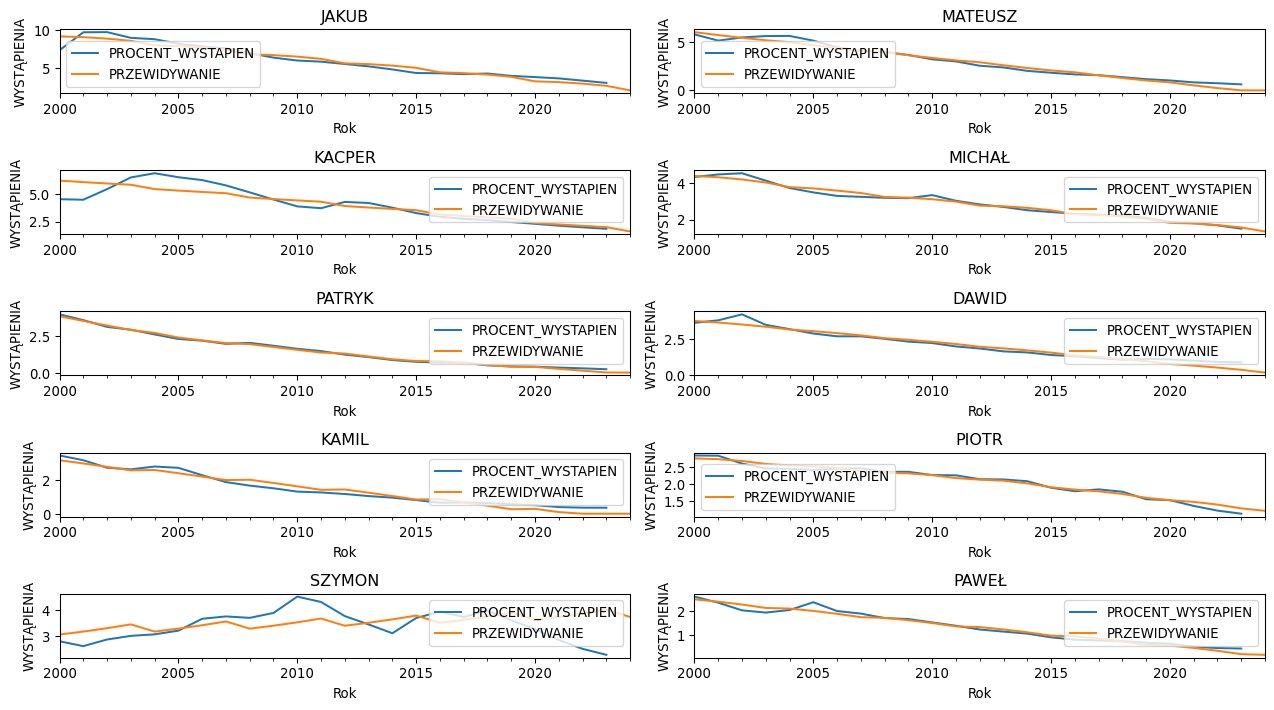

In [160]:
fig, ax = plt.subplots(5,2, figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()
for ax_ ,name in enumerate(p['IMIĘ_PIERWSZE'].unique()[:10]):
    p_ = p.loc[p['IMIĘ_PIERWSZE'] == name]
    p_.plot(x='ds', y='y', ax=ax[ax_], label='PROCENT_WYSTAPIEN')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='PRZEWIDYWANIE')
    ax[ax_].set_title(name)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Rok')
    ax[ax_].set_ylabel('WYSTĄPIENIA')
fig.tight_layout()
plt.show()

In [166]:
p[p.ds=="2024-12-31"].sort_values(by="yhat", ascending=False).head(20)

,ds,yhat,IMIĘ_PIERWSZE,LICZBA_WYSTĄPIEŃ,PŁEĆ,LW_ROCZNA,y
1574,2024-12-31,5.839940,ANTONI,NaN,NaN,NaN,NaN
799,2024-12-31,4.910902,JAN,NaN,NaN,NaN,NaN
949,2024-12-31,4.697275,ALEKSANDER,NaN,NaN,NaN,NaN
1824,2024-12-31,4.622015,FRANCISZEK,NaN,NaN,NaN,NaN
549,2024-12-31,3.903854,FILIP,NaN,NaN,NaN,NaN
224,2024-12-31,3.735414,SZYMON,NaN,NaN,NaN,NaN
649,2024-12-31,3.203086,MIKOŁAJ,NaN,NaN,NaN,NaN
749,2024-12-31,3.172577,WOJCIECH,NaN,NaN,NaN,NaN
1449,2024-12-31,2.819503,STANISŁAW,NaN,NaN,NaN,NaN
2899,2024-12-31,2.750479,LEON,NaN,NaN,NaN,NaN
